In [889]:
import xarray as xr
import flox.xarray as fx
import numpy as np
import pandas as pd
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colormaps
import cartopy.crs as ccrs
import calendar
import gsw
import matplotlib.ticker as mticker
import matplotlib.path as mpath

In [526]:
ds_globe = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/new_test.nc', chunks={'N_PROF':10000})

In [527]:
unique_prof = np.arange(len(ds_globe['N_PROF']))
ds_globe = ds_globe.assign_coords(N_PROF=('N_PROF', unique_prof))
ds_so = ds_globe.where(ds_globe.LATITUDE.compute()<-30, drop=True)

In [776]:
ds_so

<xarray.Dataset>
Dimensions:            (N_PROF: 656862, PRES_INTERPOLATED: 1001)
Coordinates:
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 2 4 6 ... 1994 1996 1998 2000
  * N_PROF             (N_PROF) int64 5879 5880 5881 ... 2550893 2550894 2550895
    TIME               (N_PROF) datetime64[ns] 2006-04-15T13:51:43 ... 2025-0...
    LATITUDE           (N_PROF) float64 -42.64 -42.65 -42.76 ... -42.19 -40.33
    LONGITUDE          (N_PROF) float64 -4.772 -4.579 -4.508 ... -142.5 -141.7
    season             (N_PROF) <U3 'MAM' 'MAM' 'MAM' ... 'DJF' 'MAM' 'MAM'
Data variables: (12/15)
    CT                 (N_PROF, PRES_INTERPOLATED) float64 dask.array<chunksize=(3631, 1001), meta=np.ndarray>
    CYCLE_NUMBER       (N_PROF) float64 dask.array<chunksize=(3631,), meta=np.ndarray>
    DATA_MODE          (N_PROF) object dask.array<chunksize=(3631,), meta=np.ndarray>
    DIRECTION          (N_PROF) object dask.array<chunksize=(3631,), meta=np.ndarray>
    PLATFORM_NUMBER    (N_PROF) float64 dask.array<chunksize=(3631,), meta=np.ndarray>
    PRES               (N_PROF, PRES_INTERPOLATED) float32 dask.array<chunksize=(3631, 1001), meta=np.ndarray>
    ...                 ...
    TEMP               (N_PROF, PRES_INTERPOLATED) float32 dask.array<chunksize=(3631, 1001), meta=np.ndarray>
    sample_rate        (N_PROF, PRES_INTERPOLATED) float32 dask.array<chunksize=(3631, 1001), meta=np.ndarray>
    SPICE              (N_PROF, PRES_INTERPOLATED) float64 dask.array<chunksize=(3631, 1001), meta=np.ndarray>
    ILD                (N_PROF) float64 66.0 76.0 92.0 114.0 ... 28.0 38.0 40.0
    MLD                (N_PROF) float64 62.0 74.0 92.0 104.0 ... 28.0 36.0 40.0
    BLT                (N_PROF) float64 4.0 2.0 0.0 10.0 ... nan 0.0 2.0 0.0
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_by:           amf2288
    Fetched_date:         2025/03/11
    Fetched_constraints:  [x=0.00/5.00; y=40.00/45.00; z=0.0/2002.0]
    Fetched_uri:          https://data-argo.ifremer.fr/dac/coriolis/6903068/6...
    Valid uris:           ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    All uris:             ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

In [528]:
season_labels = {
    "DJF": "Summer",
    "MAM": "Autumn",
    "JJA": "Winter",
    "SON": "Spring"
}

In [530]:
ds_so = ds_so.assign_coords(season=("N_PROF", ds_so.TIME.dt.season.values))

In [531]:
# Filter data to ensure that we have some data in the shallow region
shallow_range = ds_so.PRES_INTERPOLATED <= 20
has_shallow_data = ds_so.CT.where(shallow_range).notnull().any(dim='PRES_INTERPOLATED')
ds_so_filtered = ds_so.sel(N_PROF=has_shallow_data)


In [535]:
def calculate_ILD(ds, delta_temp= -0.2):
    CT = ds.CT  # shape: (N_PROF, depth)
    P = ds.PRES_INTERPOLATED

    # Step 1: Reference temperature at 10m (fallback to 20m)
    T10 = CT.sel(PRES_INTERPOLATED=10, method='nearest')
    T20 = CT.sel(PRES_INTERPOLATED=20, method='nearest')

    # Where T10 is valid, use it; otherwise use T20
    valid_T10 = ~np.isnan(T10)
    T_ref = xr.where(valid_T10, T10, T20)
    ref_depth = xr.where(valid_T10, 10, 20)

    # Step 2: Broadcast threshold and ref_depth across all pressure levels
    threshold = T_ref + delta_temp
    threshold_b = threshold.broadcast_like(CT)
    ref_depth_b = ref_depth.broadcast_like(P)

    # Step 3: Apply mask for threshold crossing and depth condition
    mask = (CT < threshold_b) & (P > ref_depth_b)

    # Step 4: Find minimum depth where condition is met (ILD)
    masked_pres = P.where(mask)
    ild = masked_pres.min(dim='PRES_INTERPOLATED')

    return ild


In [536]:
def calculate_MLD(ds, delta_temp = -0.2):
    CT = ds.CT
    SA = ds.SA
    P = ds.PRES_INTERPOLATED
    SIG0 = ds.SIG0
    
    T10 = CT.sel(PRES_INTERPOLATED = 10, method = 'nearest')
    T20 = CT.sel(PRES_INTERPOLATED = 20, method = 'nearest')
    p_ref = 0 
    
    valid_T10 = ~np.isnan(T10)
    ref_depth = xr.where(valid_T10, 10, 20)
    T_ref = xr.where(valid_T10, T10, T20)
    SA_ref = SA.sel(PRES_INTERPOLATED = ref_depth, method = 'nearest')
    SIG0_ref = SIG0.sel(PRES_INTERPOLATED = ref_depth, method = 'nearest')

    SIG0_colder = gsw.density.sigma0(SA_ref, T_ref + delta_temp)
    delta_rho = SIG0_colder - SIG0_ref
    
    # Plus because of increase of density
    threshold = SIG0_ref + delta_rho
    threshold_b = threshold.broadcast_like(SIG0)
    ref_depth_b = ref_depth.broadcast_like(P)
    
    mask = (SIG0 > threshold_b) & (P > ref_depth_b)
    
    masked_pres = P.where(mask)
    mld = masked_pres.min(dim='PRES_INTERPOLATED')
    
    return mld
    

In [537]:
ds_so['ILD'] = calculate_ILD(ds_so).compute()
ds_so['MLD'] = calculate_MLD(ds_so).compute()

/home.ufs/jp4778/.conda/envs/pangeo/lib/python3.10/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/home.ufs/jp4778/.conda/envs/pangeo/lib/python3.10/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


In [539]:
def calculate_BLT(ds):
    BLT = ds.ILD - ds.MLD
    BLT = BLT.where(ds.ILD.notnull() & ds.MLD.notnull())
    return BLT

In [540]:
ds_so['BLT'] = calculate_BLT(ds_so).compute()

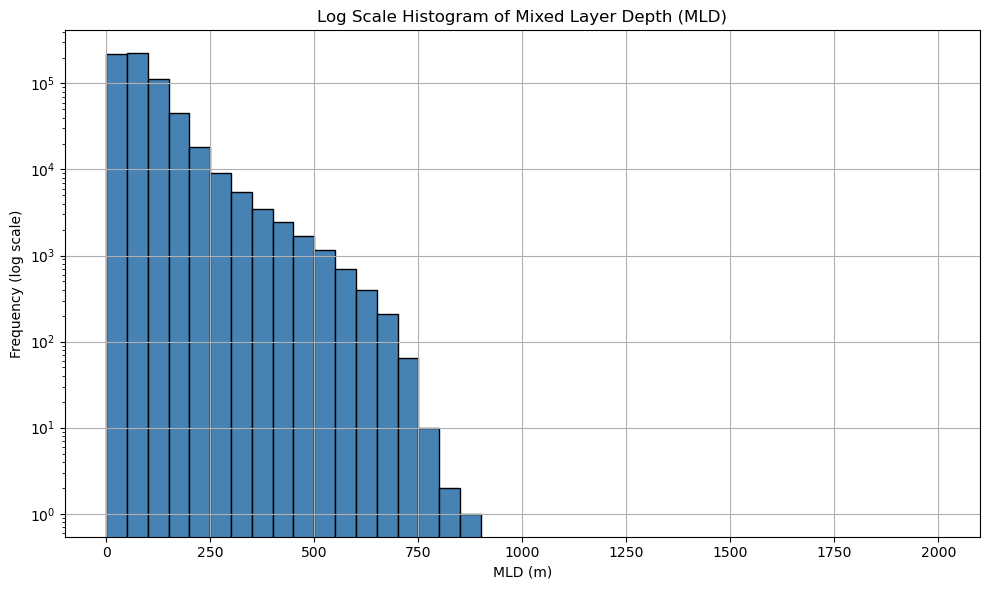

In [1092]:
import matplotlib.pyplot as plt
import numpy as np

# Use ggplot style
plt.style.use('default')

# Extract and filter BLT values
mld_values = ds_so['MLD'].values.flatten()
mld_values = mld_values[(mld_values > 0) & ~np.isnan(mld_values)]

# Define bin edges every 50 m, up to the max BLT
max_val = np.ceil(blt_values.max() / 50) * 50
bins = np.arange(0, max_val + 50, 50)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(mld_values, bins=bins, color='steelblue', edgecolor='black', log=True)

# Labels and title
plt.xlabel("MLD (m)")
plt.ylabel("Frequency (log scale)")
plt.title("Log Scale Histogram of Mixed Layer Depth (MLD)")

plt.grid(True)
plt.tight_layout()
plt.show()

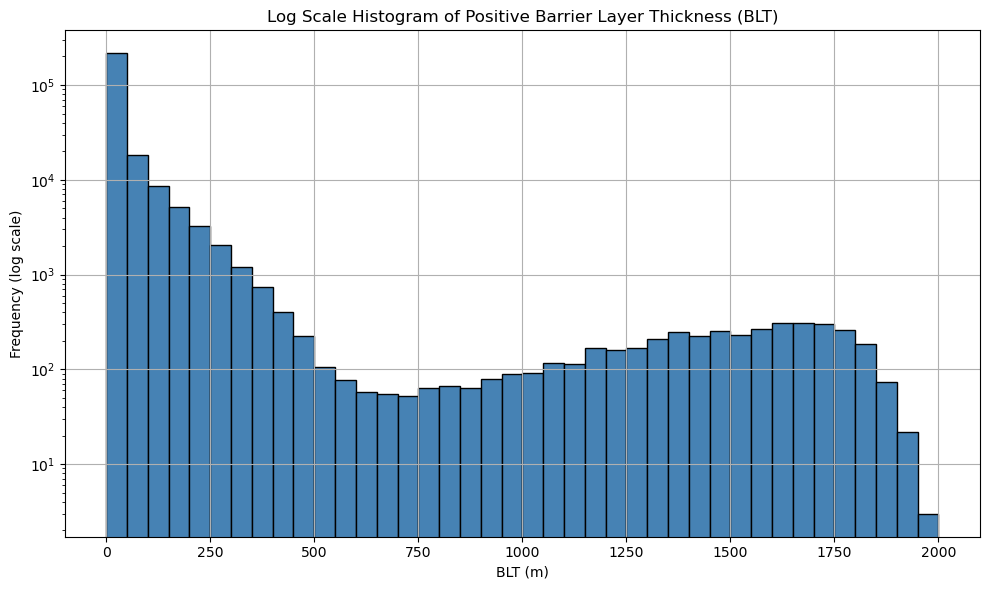

In [792]:
import matplotlib.pyplot as plt
import numpy as np

# Use ggplot style
plt.style.use('default')

# Extract and filter BLT values
blt_values = ds_so['BLT'].values.flatten()
blt_values = blt_values[(blt_values > 0) & ~np.isnan(blt_values)]

# Define bin edges every 50 m, up to the max BLT
max_val = np.ceil(blt_values.max() / 50) * 50
bins = np.arange(0, max_val + 50, 50)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(blt_values, bins=bins, color='steelblue', edgecolor='black', log=True)

# Labels and title
plt.xlabel("BLT (m)")
plt.ylabel("Frequency (log scale)")
plt.title("Log Scale Histogram of Positive Barrier Layer Thickness (BLT)")

plt.grid(True)
plt.tight_layout()
plt.show()


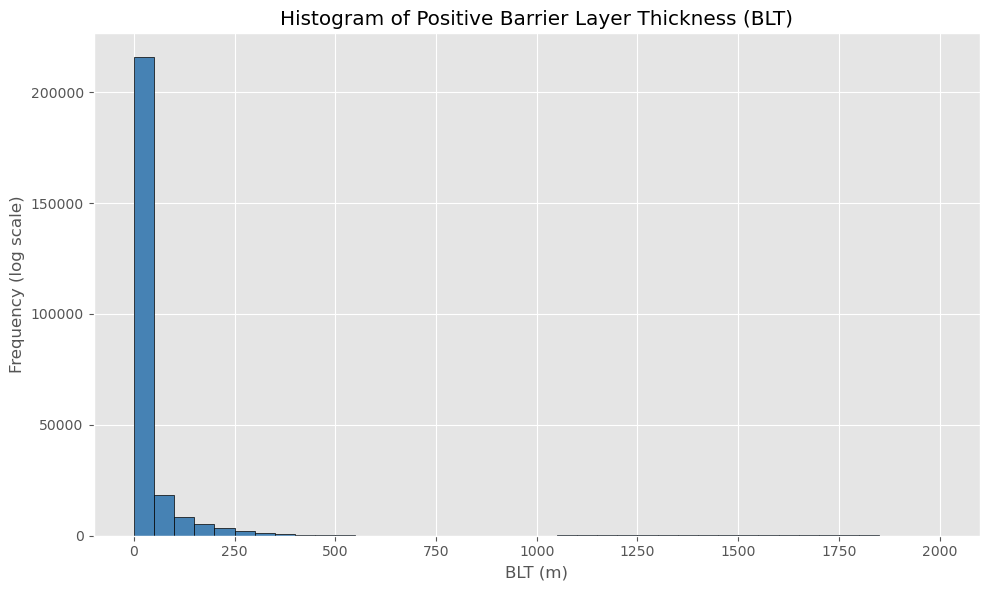

In [757]:
import matplotlib.pyplot as plt
import numpy as np

# Use ggplot style
plt.style.use('ggplot')

# Extract and filter BLT values
blt_values = ds_so['BLT'].values.flatten()
blt_values = blt_values[(blt_values > 0) & ~np.isnan(blt_values)]

# Define bin edges every 50 m, up to the max BLT
max_val = np.ceil(blt_values.max() / 50) * 50
bins = np.arange(0, max_val + 50, 50)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(blt_values, bins=bins, color='steelblue', edgecolor='black', log=False)

# Labels and title
plt.xlabel("BLT (m)")
plt.ylabel("Frequency (log scale)")
plt.title("Histogram of Positive Barrier Layer Thickness (BLT)")

plt.grid(True)
plt.tight_layout()
plt.show()


In [541]:
ds_so_final = ds_so.where((ds_so['BLT'] < 1000) & ds_so['BLT'].notnull(), drop=True)

In [543]:
def get_ds_binned(ds, lon_bins, lat_bins):
    """
    Bin an xarray Dataset by 3-degree latitude and longitude bins,
    replacing Interval dimensions with bin centers.
    
    Parameters:
        ds : xarray.Dataset
            The dataset to bin.
        lon_bins : array-like
            Bin edges for longitude (e.g. np.arange(-180, 181, 3))
        lat_bins : array-like
            Bin edges for latitude (e.g. np.arange(-90, 91, 3))
    
    Returns:
        xarray.Dataset
            Binned dataset with dimensions (PRES_INTERPOLATED, lon_c, lat_c)
    """

    # Step 1: Bin with fx.xarray_reduce using IntervalIndex
    ds_binned = fx.xarray_reduce(
        ds,
        'LONGITUDE',
        'LATITUDE',
        func='mean',
        expected_groups=(
            pd.IntervalIndex.from_breaks(lon_bins),
            pd.IntervalIndex.from_breaks(lat_bins),
        ),
        fill_value=np.nan,
        skipna=True
    )

    # Step 2: Create left, right, center arrays
    lon_l = np.array(lon_bins[:-1])
    lon_r = np.array(lon_bins[1:])
    lon_c = (lon_l + lon_r) / 2

    lat_l = np.array(lat_bins[:-1])
    lat_r = np.array(lat_bins[1:])
    lat_c = (lat_l + lat_r) / 2

    # Step 3: Replace Interval dims with center dims
    ds_binned = ds_binned.assign_coords({
        "lon_c": ("LONGITUDE", [iv.mid for iv in ds_binned['LONGITUDE'].values]),
        "lat_c": ("LATITUDE", [iv.mid for iv in ds_binned['LATITUDE'].values]),
        "lon_l": ("LONGITUDE", lon_l),
        "lon_r": ("LONGITUDE", lon_r),
        "lat_l": ("LATITUDE", lat_l),
        "lat_r": ("LATITUDE", lat_r),
    })

    ds_binned = ds_binned.swap_dims({"LONGITUDE": "lon_c", "LATITUDE": "lat_c"})

    return ds_binned

In [544]:
lon_bins = np.arange(-180,181,1)
so_lat_bins = np.arange(-90,-29,1)

In [545]:
seasonal_groups = ds_so_final.groupby('TIME.season')

ds_so_layers_seasonal = {
    season: get_ds_binned(group, lon_bins, so_lat_bins)[['ILD', 'MLD', 'BLT']].compute()
    for season, group in seasonal_groups
}

In [871]:
seasonal_groups_unfiltered = ds_so.groupby('TIME.season')

ds_so_seasonal_unfiltered = {
    season: get_ds_binned(group, lon_bins, so_lat_bins)[['ILD', 'MLD', 'BLT']].compute()
    for season, group in seasonal_groups_unfiltered}

In [546]:
ordered_seasons = ["DJF", "MAM", "JJA", "SON"]
season_labels = {
    "DJF": "Summer",
    "MAM": "Autumn",
    "JJA": "Winter",
    "SON": "Spring"
}

/tmp/ipykernel_61675/2855092867.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


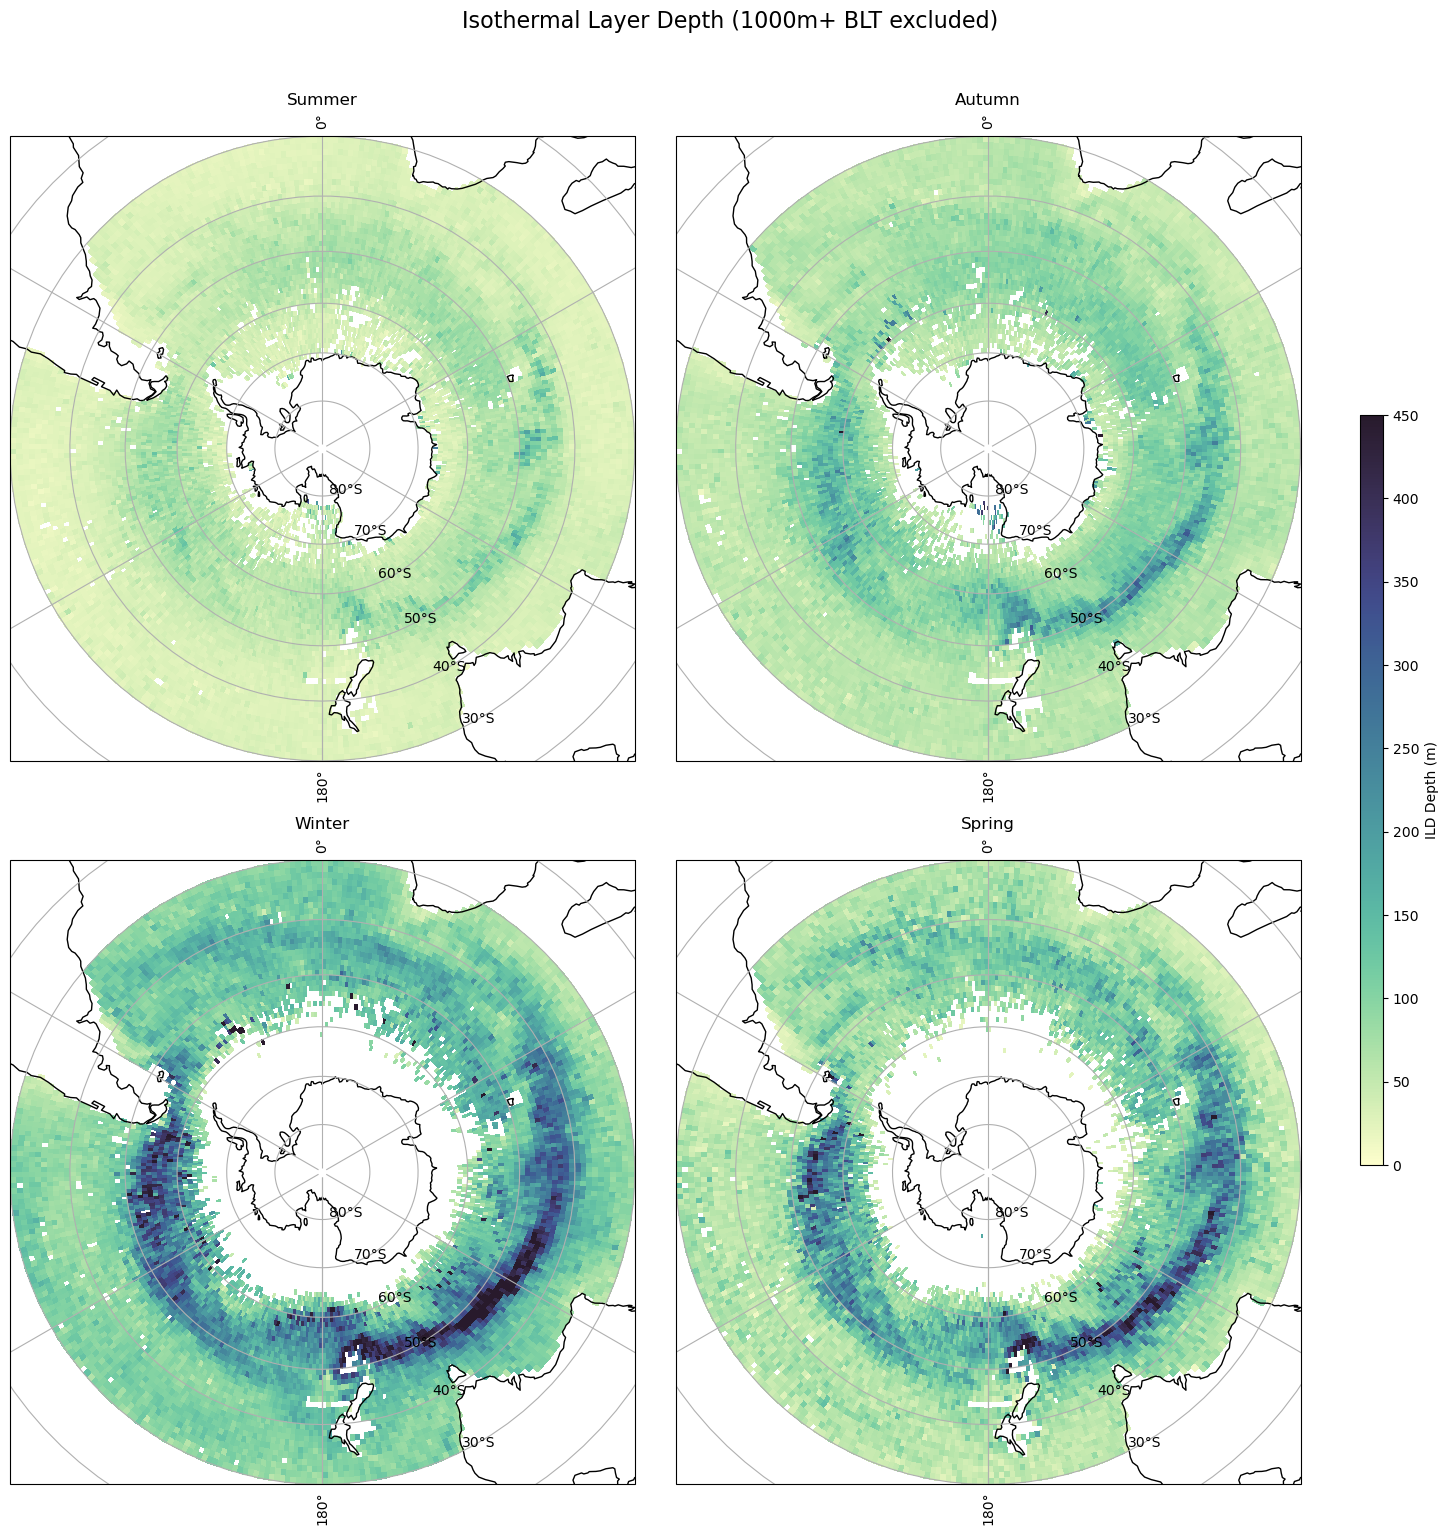

In [547]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15), 
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs = axs.ravel()

for i, season in enumerate(ordered_seasons):
    ds = ds_so_layers_seasonal[season]
    ax = axs[i]
    ax.coastlines()
    ax.gridlines(draw_labels=True)

    # Plot with consistent color limits
    ds.ILD.plot(
        ax=ax,
        x='lon_c',
        y='lat_c',
        transform=ccrs.PlateCarree(),
        vmin=0,
        vmax=450,
        cmap=cmo.deep,
        add_colorbar=False
    )
    ax.set_title(season_labels[season])
    
# Colorbar
cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
plt.colorbar(axs[0].collections[0], cax=cbar_ax, label="ILD Depth (m)")

# Title
plt.suptitle("Isothermal Layer Depth (1000m+ BLT excluded)", fontsize=16, y=1.02)

plt.tight_layout(rect=[0, 0, 0.9, 1])


/tmp/ipykernel_61675/2771547239.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


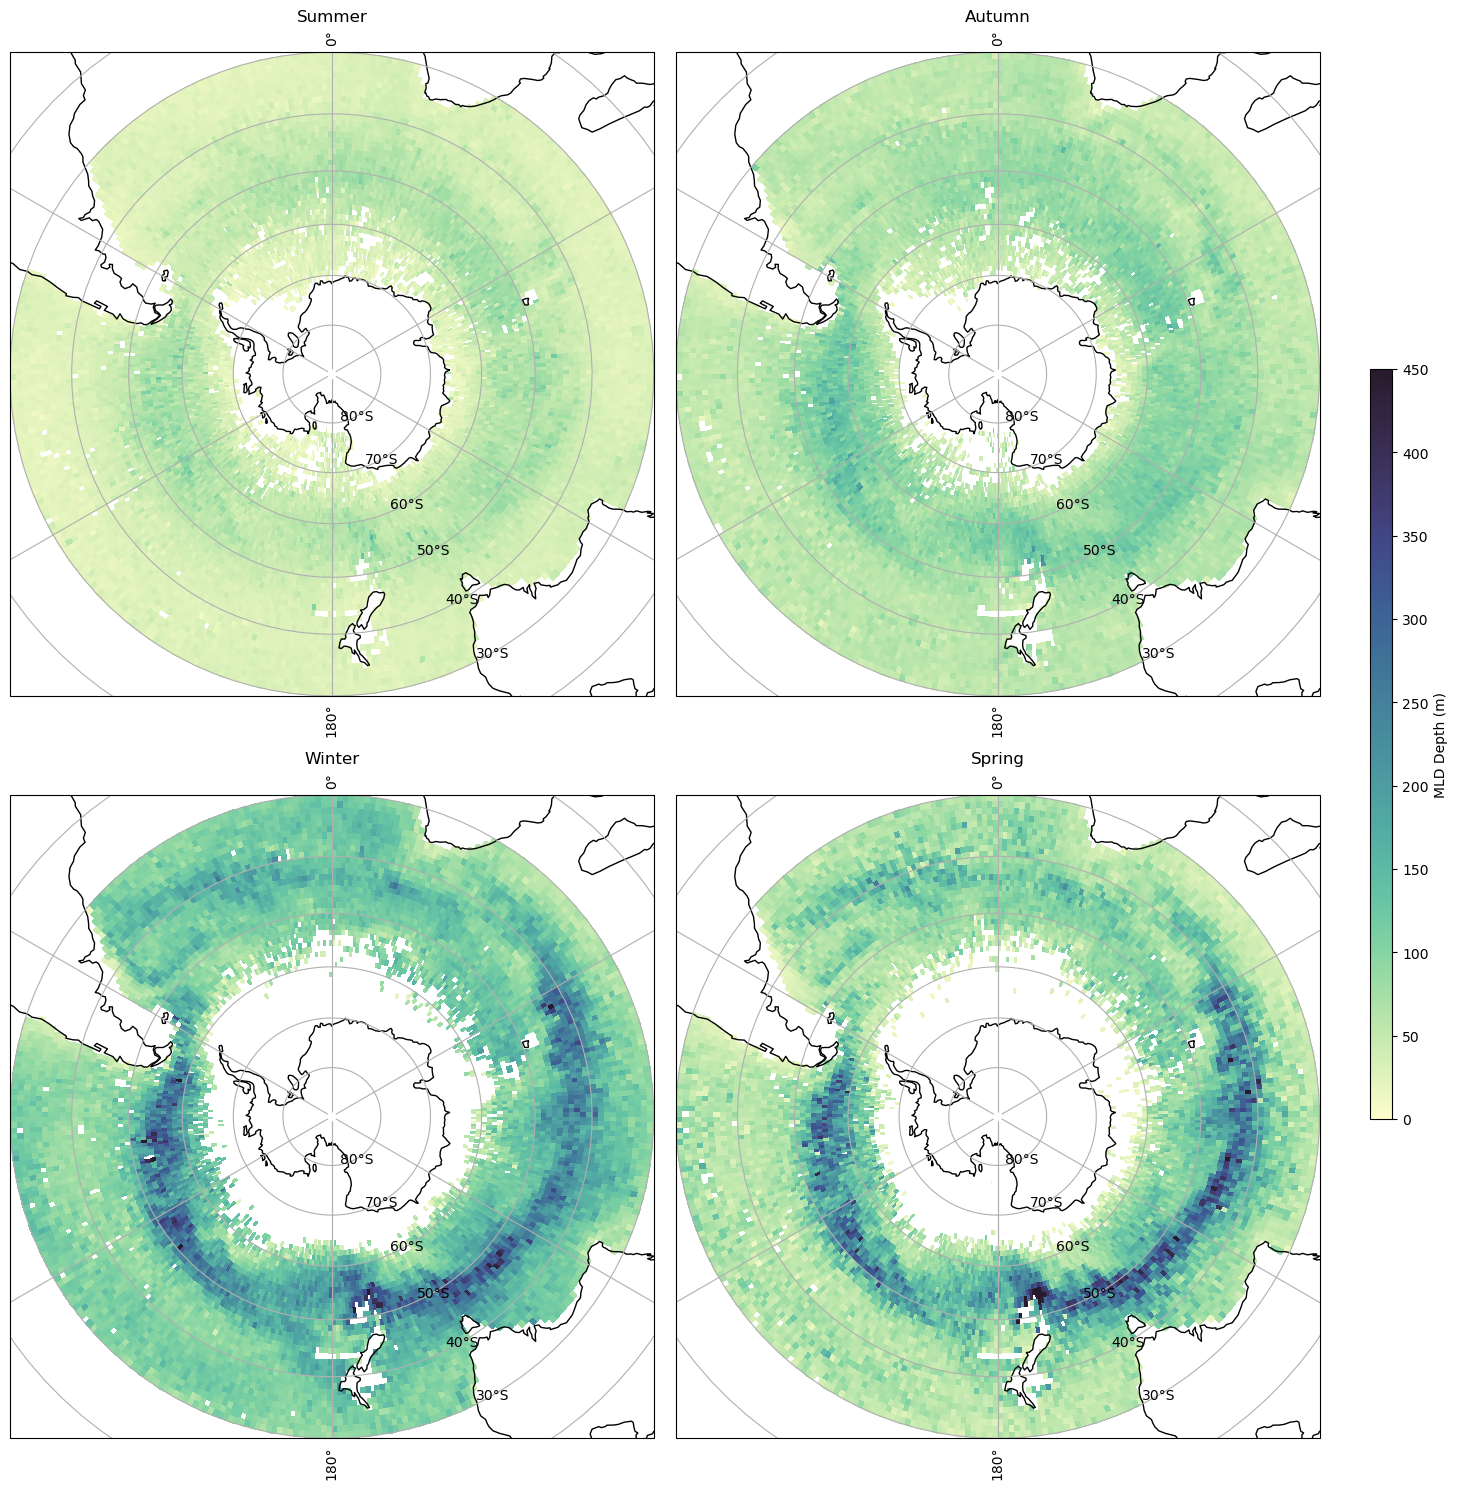

In [548]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15), 
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs = axs.ravel()

for i, season in enumerate(ordered_seasons):
    ds = ds_so_layers_seasonal[season]
    ax = axs[i]
    ax.coastlines()
    ax.gridlines(draw_labels=True)

    # Plot with consistent color limits
    ds.MLD.plot(
        ax=ax,
        x='lon_c',
        y='lat_c',
        transform=ccrs.PlateCarree(),
        vmin=0,
        vmax=450,
        cmap=cmo.deep,
        add_colorbar=False
    )
    ax.set_title(season_labels[season])
    
cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
plt.colorbar(axs[0].collections[0], cax=cbar_ax, label="MLD Depth (m)")

plt.tight_layout(rect=[0, 0, 0.9, 1])

In [567]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """
    Return a truncated colormap from cmap between minval and maxval.

    Parameters:
    - cmap: original colormap instance or name
    - minval: float, start of the colormap (0=bottom)
    - maxval: float, end of the colormap (1=top)
    - n: number of colors in new colormap

    Returns:
    - new truncated LinearSegmentedColormap
    """
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
    colors = cmap(np.linspace(minval, maxval, n))
    new_cmap = LinearSegmentedColormap.from_list(f'trunc({cmap.name},{minval:.2f},{maxval:.2f})', colors)
    return new_cmap

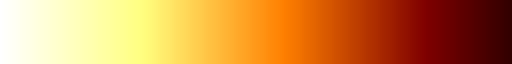

In [600]:
original_cmap = 'afmhot_r'
trunc_cmap_hot = truncate_colormap(original_cmap, 0, 0.9)
trunc_cmap_hot

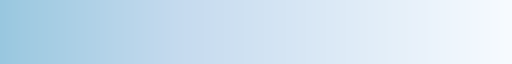

In [695]:
original_cmap = 'Blues_r'
trunc_cmap_cool = truncate_colormap(original_cmap, 0.61)
trunc_cmap_cool

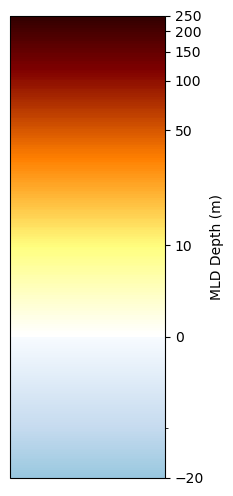

In [696]:
from matplotlib.colors import SymLogNorm, LinearSegmentedColormap
from matplotlib.ticker import ScalarFormatter

# Assuming trunc_cmap_cool and trunc_cmap_hot exist

vmin, vmax = -20, 250
linthresh = 10

norm = SymLogNorm(linthresh=linthresh, linscale=0.5, vmin=vmin, vmax=vmax, base=10)

n_colors = 256
zero_frac = norm(0)  # breakpoint fraction

n_cool = int(n_colors * zero_frac)
n_hot = n_colors - n_cool

colors_cool = trunc_cmap_cool(np.linspace(0, 1, n_cool))
colors_hot = trunc_cmap_hot(np.linspace(0, 1, n_hot))

combined_colors = np.vstack((colors_cool, colors_hot))
combined_cmap = LinearSegmentedColormap.from_list('combined_cmap', combined_colors)

fig, ax = plt.subplots(figsize=(2, 6))  # Taller figure for vertical bar

from matplotlib.cm import ScalarMappable
sm = ScalarMappable(cmap=combined_cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, cax=ax, orientation='vertical')

ticks = [-20, 0, 10, 50, 100, 150, 200, 250]
cbar.set_ticks(ticks)
cbar.set_label("MLD Depth (m)")

# Use ScalarFormatter to prevent scientific notation
formatter = ScalarFormatter(useMathText=False)
formatter.set_scientific(False)
cbar.ax.yaxis.set_major_formatter(formatter)

plt.show()


/tmp/ipykernel_61675/4405597.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


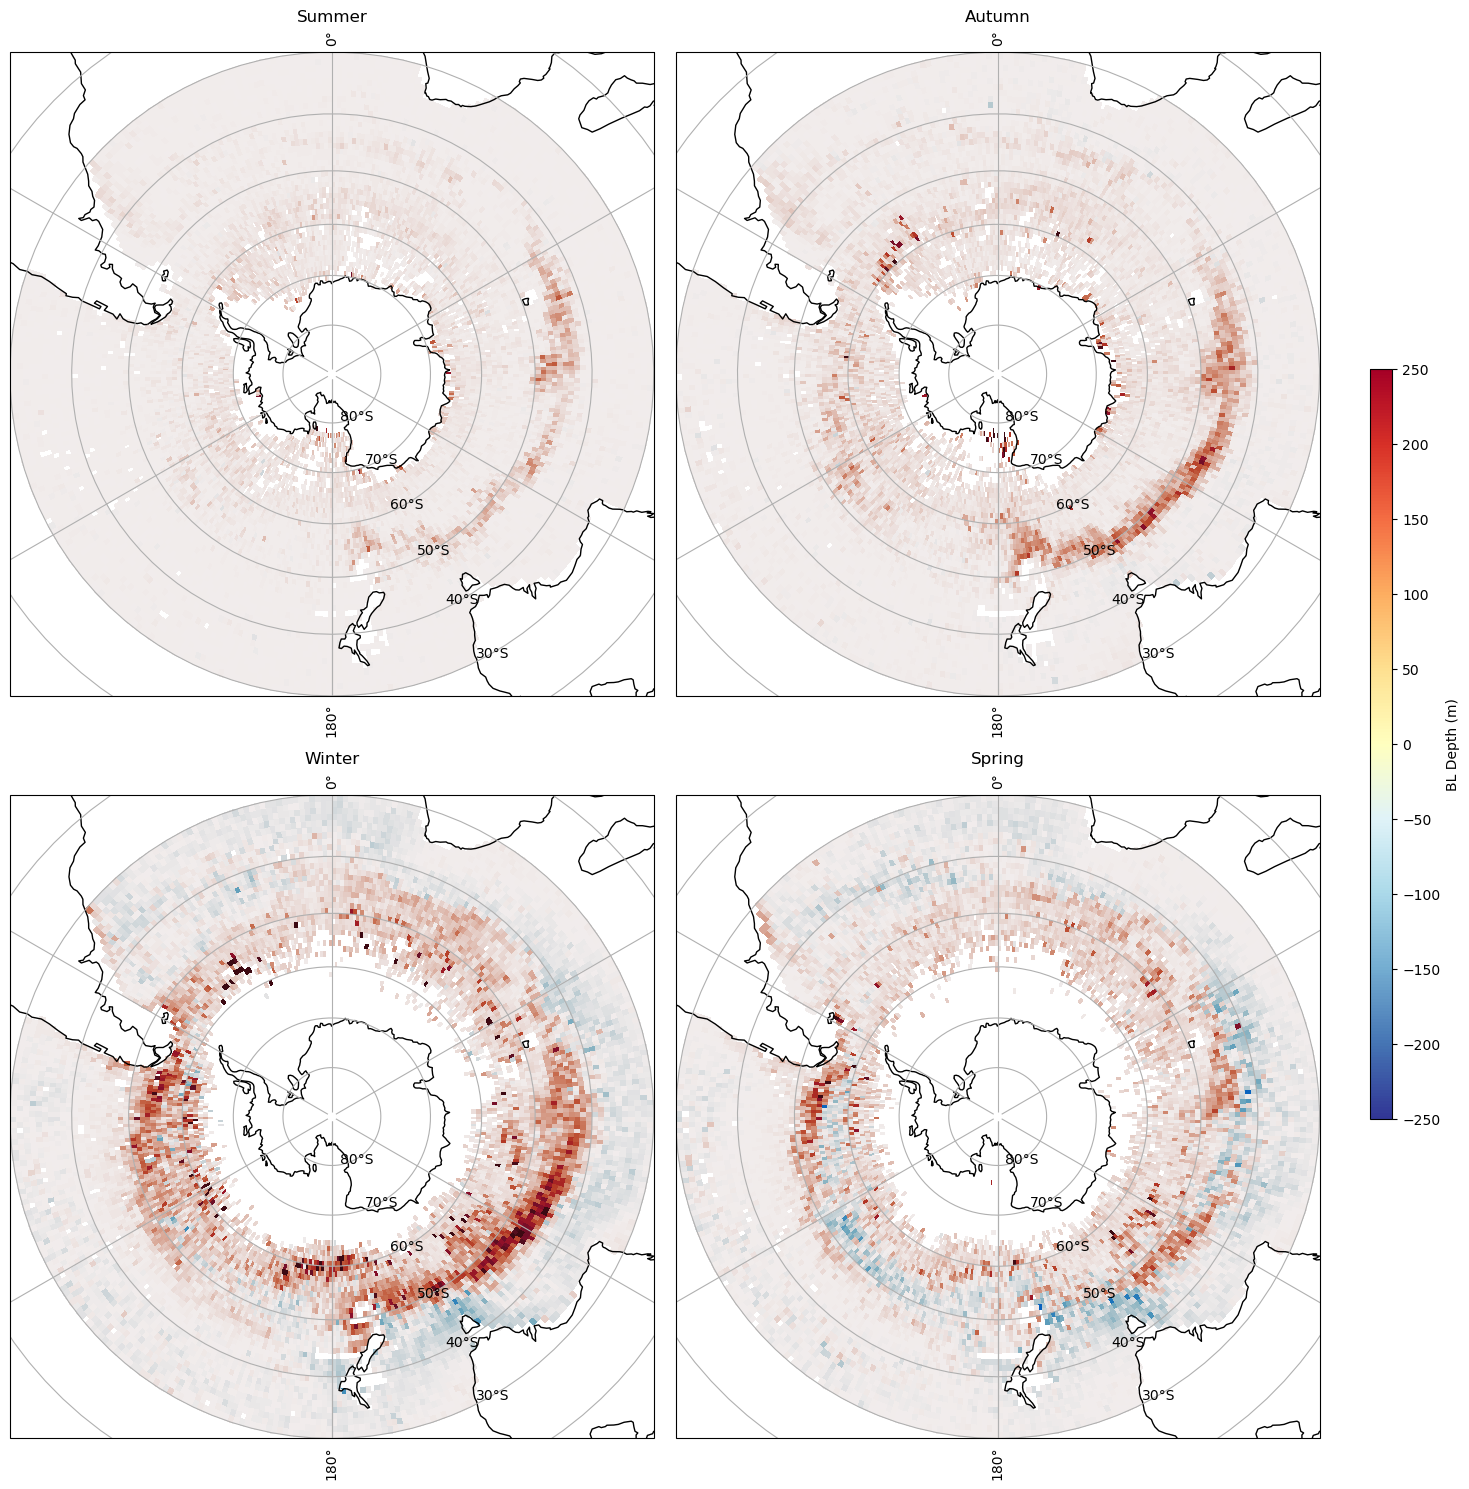

In [795]:
vmin, vmax = -250, 250
norm = Normalize(vmin=vmin, vmax=vmax)

# === Plotting the 4 seasons ===
fig, axs = plt.subplots(2, 2, figsize=(15, 15),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs = axs.ravel()

for i, season in enumerate(ordered_seasons):
    ds = ds_so_layers_seasonal[season]
    ax = axs[i]
    ax.coastlines()
    ax.gridlines(draw_labels=True)

    ds.BLT.plot(
        ax=ax,
        x='lon_c',
        y='lat_c',
        transform=ccrs.PlateCarree(),
        cmap=cmo.balance,
        norm=norm,
        add_colorbar=False
    )
    ax.set_title(season_labels[season])

# === Shared vertical colorbar ===
cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

ticks = np.linspace(vmin, vmax, 11)
cbar = fig.colorbar(sm, cax=cbar_ax, ticks=ticks, orientation='vertical')
cbar.set_label("BL Depth (m)")

formatter = ScalarFormatter(useMathText=False)
formatter.set_scientific(False)
cbar.ax.yaxis.set_major_formatter(formatter)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


/tmp/ipykernel_61675/2167676601.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


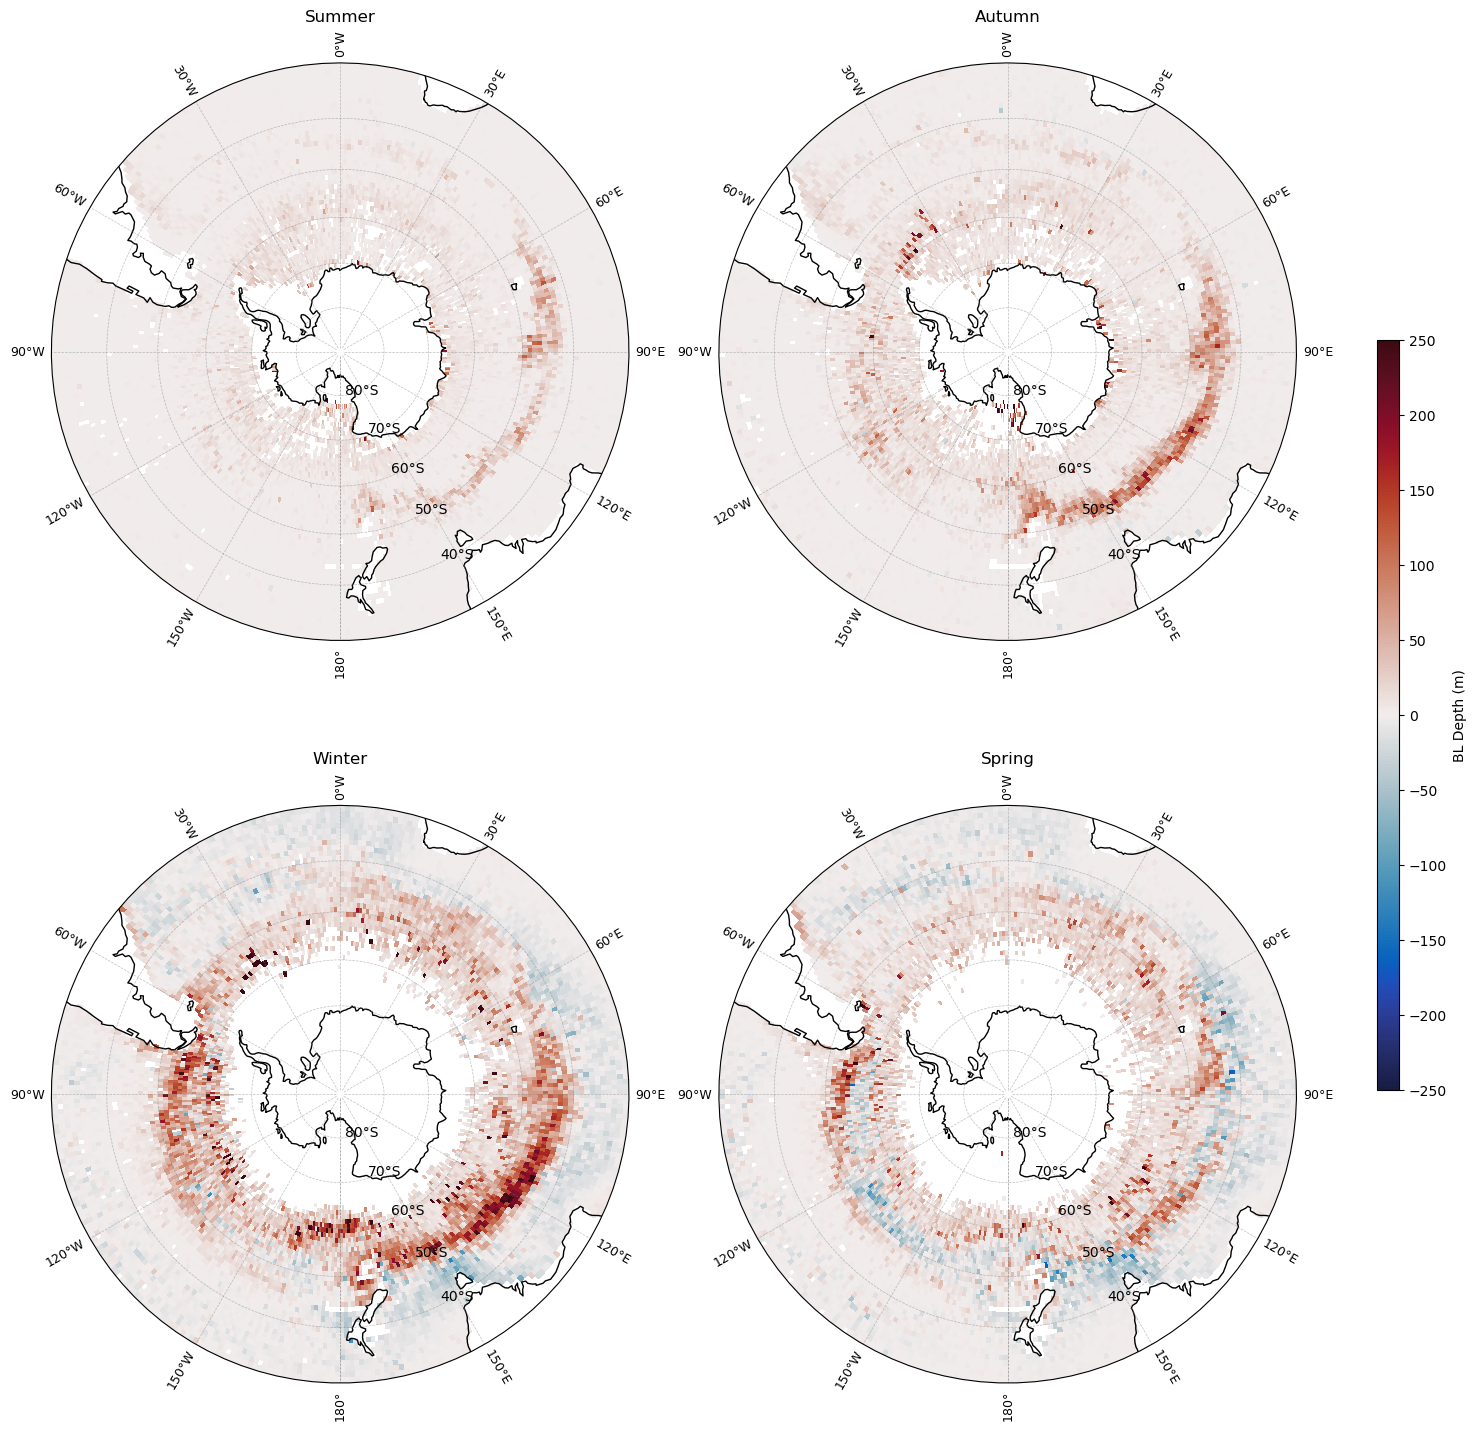

In [819]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import ScalarFormatter
from matplotlib.patches import Circle
from cartopy.mpl.ticker import LongitudeFormatter
from matplotlib.path import Path

# === Plotting settings ===
vmin, vmax = -250, 250
norm = Normalize(vmin=vmin, vmax=vmax)
ticks = np.linspace(vmin, vmax, 11)

# === Create figure ===
fig, axs = plt.subplots(2, 2, figsize=(15, 15),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs = axs.ravel()

for i, season in enumerate(ordered_seasons):
    ds = ds_so_layers_seasonal[season]
    ax = axs[i]

    # --- Plot BLT ---
    ds.BLT.plot(
        ax=ax,
        x='lon_c',
        y='lat_c',
        transform=ccrs.PlateCarree(),
        cmap=cmo.balance,
        norm=norm,
        add_colorbar=False
    )

    # --- Circular boundary (South Polar) ---
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T * radius + center
    ax.set_boundary(Path(verts), transform=ax.transAxes)

    # --- Coastlines and grid ---
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.right_labels = gl.top_labels = True
    gl.left_labels = gl.bottom_labels = True
    gl.xlocator = plt.MultipleLocator(30)
    gl.xlabel_style = {'size': 9}
    gl.xformatter = LongitudeFormatter(zero_direction_label=True)

    ax.set_title(season_labels[season])

# === Shared vertical colorbar ===
cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
sm = ScalarMappable(cmap=cmo.balance, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, cax=cbar_ax, ticks=ticks, orientation='vertical')
cbar.set_label("BL Depth (m)")

formatter = ScalarFormatter(useMathText=False)
formatter.set_scientific(False)
cbar.ax.yaxis.set_major_formatter(formatter)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


/tmp/ipykernel_61675/2489126989.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


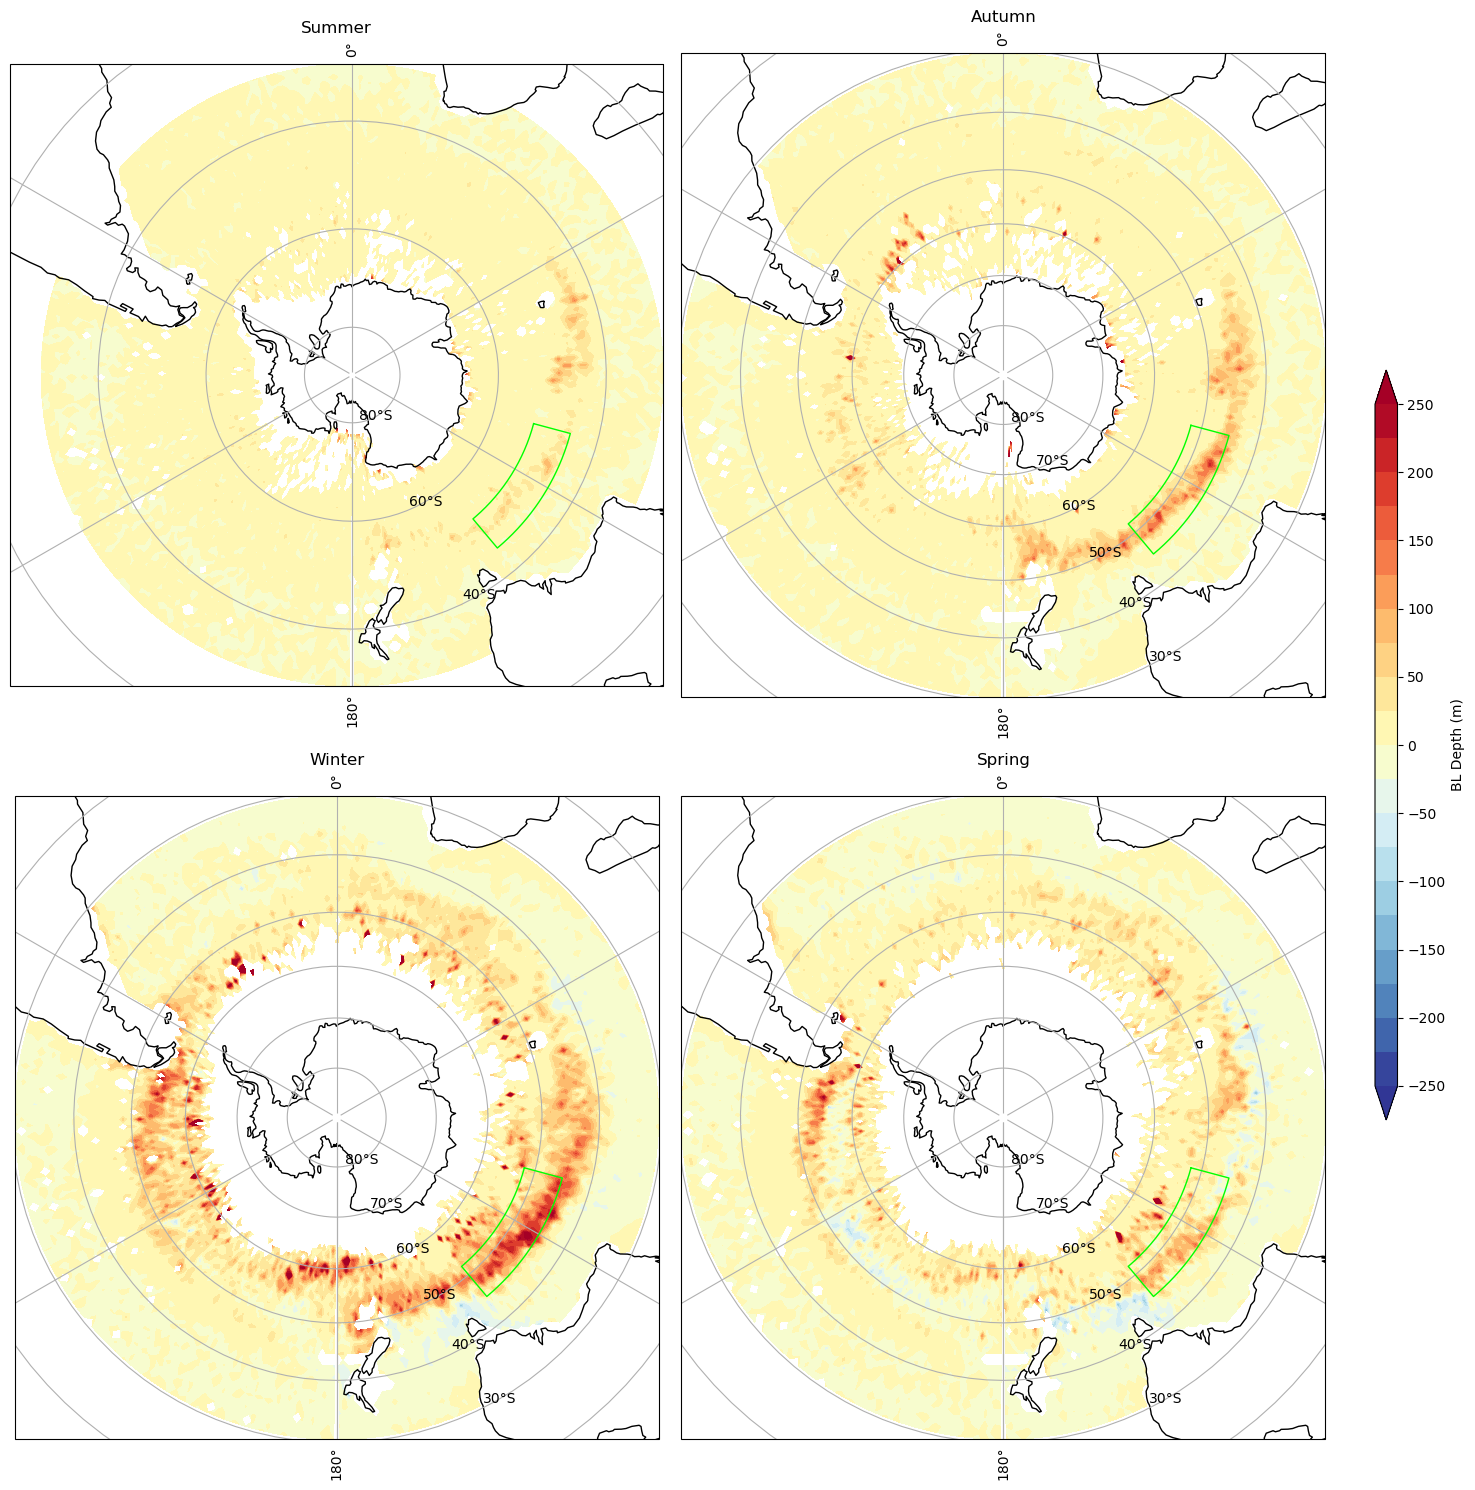

In [1088]:
# === Set linear normalization and diverging colormap ===
vmin, vmax = -250, 250
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.RdYlBu_r

# === Define discrete contour levels ===
levels = np.arange(vmin, vmax + 1, 25)  # every 25 units

# === Plotting the 4 seasons ===
fig, axs = plt.subplots(2, 2, figsize=(15, 15),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs = axs.ravel()

# === Define the box coordinates ===
lon_min, lon_max = 105, 140  # 105°E to 140°E
lat_min, lat_max = -52, -45  # 52°S to 45°S

# === Create denser edges for smoothness ===
n_points = 100  # Increase for smoother curves

# Bottom edge (lat_min, lon from min to max)
bottom_lons = np.linspace(lon_min, lon_max, n_points)
bottom_lats = np.full_like(bottom_lons, lat_min)

# Top edge (lat_max, lon from min to max)
top_lons = np.linspace(lon_min, lon_max, n_points)
top_lats = np.full_like(top_lons, lat_max)

# Left edge (lon_min, lat from min to max)
left_lons = np.full(n_points, lon_min)
left_lats = np.linspace(lat_min, lat_max, n_points)

# Right edge (lon_max, lat from min to max)
right_lons = np.full(n_points, lon_max)
right_lats = np.linspace(lat_min, lat_max, n_points)

# Combine all edges (in order: bottom → right → top → left → back to start)
box_lons = np.concatenate([bottom_lons, right_lons, top_lons[::-1], left_lons[::-1], [lon_min]])
box_lats = np.concatenate([bottom_lats, right_lats, top_lats[::-1], left_lats[::-1], [lat_min]])

for i, season in enumerate(ordered_seasons):
    ds = ds_so_layers_seasonal[season]
    ax = axs[i]
    ax.coastlines()
    ax.gridlines(draw_labels=True)

    lon = ds.lon_c.values
    lat = ds.lat_c.values
    data = ds.BLT.values.T  # transpose if needed (xarray dims order)

    cf = ax.contourf(
        lon, lat, data,
        levels=levels,
        cmap=cmap,
        norm=norm,
        transform=ccrs.PlateCarree(),
        extend='both'
    )

    ax.set_title(season_labels[season])

    ax.plot(
        box_lons, box_lats,
        color='lime',  # or any color you prefer
        linewidth=1,
        transform=ccrs.PlateCarree(),
        zorder=10
    )

# === Shared vertical colorbar with discrete colors ===
cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
cbar = fig.colorbar(cf, cax=cbar_ax, ticks=levels[::2], orientation='vertical')
cbar.set_label("BL Depth (m)")

formatter = ScalarFormatter(useMathText=False)
formatter.set_scientific(False)
cbar.ax.yaxis.set_major_formatter(formatter)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

In [1071]:
prof = ds_so.isel(N_PROF = 421402)

In [1072]:
import numpy as np

def get_random_profile(target_lon, target_lat, season=None, ds = ds_so, lon_tol=1, lat_tol=1):
    # Add season coordinate if not present
    if 'season' not in ds.coords:
        ds = ds.assign_coords(season=ds['TIME'].dt.season)
    
    # Filter by season if specified
    if season is not None:
        ds = ds.where(ds.season == season, drop=True)
    
    # Filter by longitude and latitude tolerance box
    nearby = ds.where(
        (np.abs(ds.LONGITUDE - target_lon) < lon_tol) &
        (np.abs(ds.LATITUDE - target_lat) < lat_tol),
        drop=True
    )
    
    n_profiles = nearby.dims.get('N_PROF', 0)
    if n_profiles == 0:
        print("No profiles found near that location (and season).")
        return None
    
    # Randomly select one profile index
    random_idx = np.random.choice(n_profiles)
    prof = nearby.isel(N_PROF=random_idx)
    
    return prof


In [1041]:
prof = get_random_profile(176, -74, 'DJF')

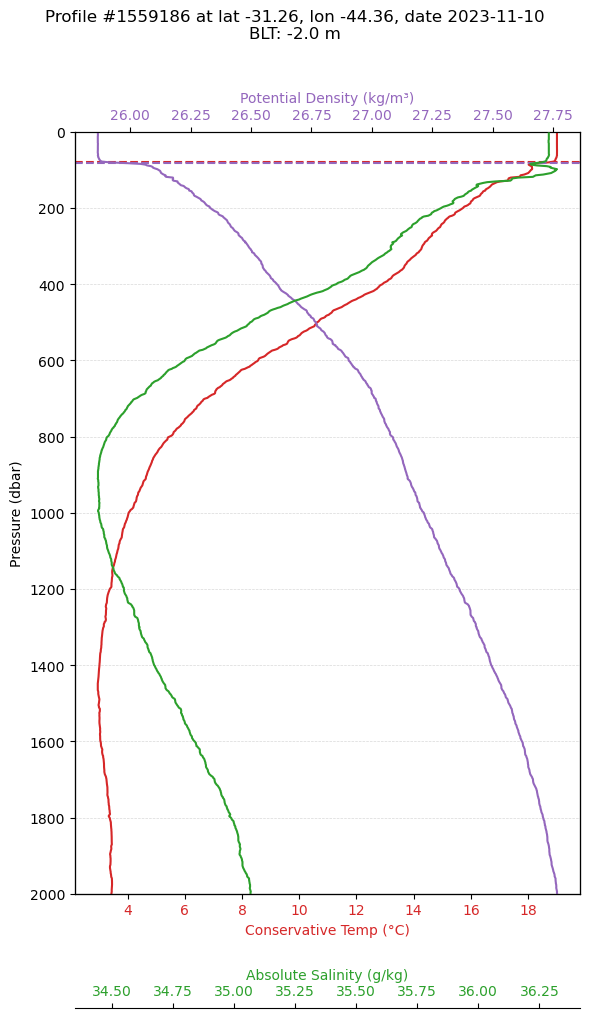

In [1073]:
y = prof.PRES_INTERPOLATED

# Base axis (CT)
fig, ax_ct = plt.subplots(figsize=(6, 10))
ax_ct.invert_yaxis()
ax_ct.plot(prof.CT, y, color='tab:red')
ax_ct.set_xlabel("Conservative Temp (°C)", color='tab:red')
ax_ct.set_ylabel("Pressure (dbar)")
ax_ct.tick_params(axis='x', labelcolor='tab:red')

# Set y-axis ticks from 0 to 2000 at 200 intervals
ax_ct.set_yticks(np.arange(0, 2001, 200))  # 0, 200, 400,..., 2000
ax_ct.grid(axis='y', color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
# Add ILD line
ild = prof.ILD.values.item()
mld = prof.MLD.values.item()
ax_ct.axhline(y=ild, color='tab:red', linestyle='--', linewidth=1.5,
             label=f'ILD ({ild:.1f} dbar)')
ax_ct.axhline(y = mld, color= 'tab:purple', linestyle = '--', linewidth = 1.5)

# Top axis (SIG0)
ax_sig0 = ax_ct.twiny()
ax_sig0.plot(prof.SIG0, y, color='tab:purple')
ax_sig0.set_xlabel("Potential Density (kg/m³)", color='tab:purple')
ax_sig0.tick_params(axis='x', labelcolor='tab:purple')

# Third axis (SA)
ax_sa = ax_ct.twiny()
ax_sa.spines["top"].set_position(("axes", -0.15))
ax_sa.plot(prof.SA, y, color='tab:green')
ax_sa.set_xlabel("Absolute Salinity (g/kg)", color='tab:green')
ax_sa.tick_params(axis='x', labelcolor='tab:green')
ax_sa.xaxis.set_label_position('top')
ax_sa.xaxis.set_ticks_position('top')

# Adjust CT axis labels
ax_ct.xaxis.set_label_position('bottom')
ax_ct.xaxis.set_ticks_position('bottom')

ax_ct.set_ylim(2000, 0)

# Title
plt.suptitle(
    'Profile #{nprof} at lat {lat:.2f}, lon {lon:.2f}, date {date}\nBLT: {blt:.1f} m'.format(
        nprof=prof.N_PROF.values.item() if hasattr(prof, 'N_PROF') else 'N/A',
        lat=prof.LATITUDE.values,
        lon=prof.LONGITUDE.values,
        date=np.datetime_as_string(prof.TIME.values, unit='D'),
        blt = prof.BLT.values.item() if hasattr(prof, 'BLT') else np.nan
    ),
    y=1.02
)

plt.tight_layout()
plt.show()

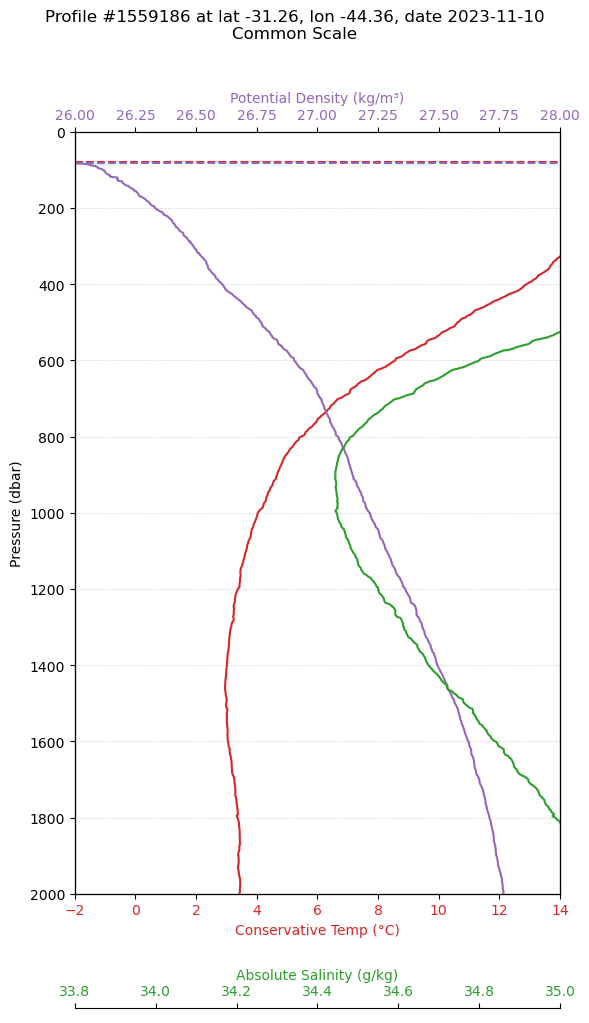

In [1074]:
y = prof.PRES_INTERPOLATED

# Base axis (CT)
fig, ax_ct = plt.subplots(figsize=(6, 10))
ax_ct.invert_yaxis()
ax_ct.plot(prof.CT, y, color='tab:red')
ax_ct.set_xlabel("Conservative Temp (°C)", color='tab:red')
ax_ct.set_ylabel("Pressure (dbar)")
ax_ct.tick_params(axis='x', labelcolor='tab:red')
ax_ct.set_xlim(-2, 14)  # Fixed CT range

# Set y-axis ticks from 0 to 2000 at 200 intervals
ax_ct.set_yticks(np.arange(0, 2001, 200))
ax_ct.grid(axis='y', color='gray', linestyle='--', linewidth=0.5, alpha=0.3)

# Add ILD and MLD lines
ild = prof.ILD.values.item()
mld = prof.MLD.values.item()
ax_ct.axhline(y=ild, color='tab:red', linestyle='--', linewidth=1.5, label=f'ILD ({ild:.1f} dbar)')
ax_ct.axhline(y=mld, color='tab:purple', linestyle='--', linewidth=1.5)

# Top axis (SIG0)
ax_sig0 = ax_ct.twiny()
ax_sig0.plot(prof.SIG0, y, color='tab:purple')
ax_sig0.set_xlabel("Potential Density (kg/m³)", color='tab:purple')
ax_sig0.tick_params(axis='x', labelcolor='tab:purple')
ax_sig0.set_xlim(26, 28)  # Fixed SIG0 range

# Third axis (SA)
ax_sa = ax_ct.twiny()
ax_sa.spines["top"].set_position(("axes", -0.15))
ax_sa.plot(prof.SA, y, color='tab:green')
ax_sa.set_xlabel("Absolute Salinity (g/kg)", color='tab:green')
ax_sa.tick_params(axis='x', labelcolor='tab:green')
ax_sa.xaxis.set_label_position('top')
ax_sa.xaxis.set_ticks_position('top')
ax_sa.set_xlim(33.8, 35)  # Fixed SA range

# Adjust CT axis labels
ax_ct.xaxis.set_label_position('bottom')
ax_ct.xaxis.set_ticks_position('bottom')
ax_ct.set_ylim(2000, 0)

# Title with profile number
plt.suptitle(
    'Profile #{} at lat {:.2f}, lon {:.2f}, date {}\nCommon Scale'.format(
        prof.N_PROF.values.item() if hasattr(prof, 'N_PROF') else 'N/A',
        prof.LATITUDE.values,
        prof.LONGITUDE.values,
        np.datetime_as_string(prof.TIME.values, unit='D')
    ),
    y=1.02
)

plt.tight_layout()
plt.show()


/tmp/ipykernel_61675/3080114673.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


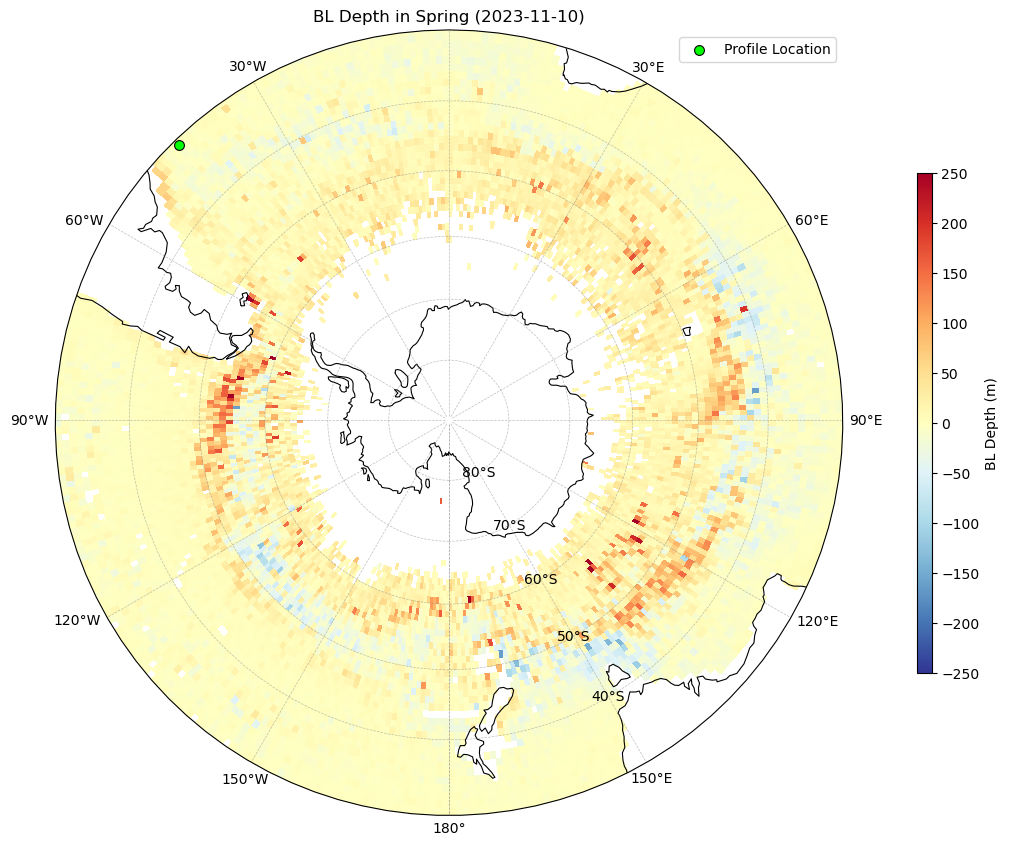

In [1075]:
import matplotlib.path as mpath
import matplotlib.ticker as mticker
from matplotlib.ticker import ScalarFormatter

prof_season = prof.TIME.dt.season.item()
prof_lon = prof.LONGITUDE.values.item()
prof_lat = prof.LATITUDE.values.item()

# Extract the seasonal dataset
ds = ds_so_layers_seasonal[prof_season]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.SouthPolarStereo()})

# Set geographic extent to Southern Hemisphere south of 30°S
ax.set_extent([-180, 180, -90, -30], crs=ccrs.PlateCarree())

# Circular boundary at 30°S
theta = np.linspace(0, 2 * np.pi, 100)
center = [0.5, 0.5]
radius = 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Gridlines every 30° longitude, 10° latitude
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
gl.ylocator = mticker.FixedLocator(np.arange(-80, -29, 10))  # from -80 to -30

gl.top_labels = False
gl.right_labels = False
gl.bottom_labels = True
gl.left_labels = True

gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

gl.rotate_labels = False  # Important for polar projection, keeps labels horizontal

# Add coastlines
ax.coastlines(linewidth=0.8)

# Plot the pixelated BL depth data
lon = ds.lon_c.values
lat = ds.lat_c.values
data = ds.BLT.values.T  # Ensure correct orientation

mesh = ax.pcolormesh(
    lon, lat, data,
    cmap=cmap,
    norm=norm,
    transform=ccrs.PlateCarree()
)

# Plot profile location
ax.scatter(prof_lon, prof_lat,
           color='lime', s=50, edgecolor='black',
           linewidth=0.8, transform=ccrs.PlateCarree(),
           zorder=10, label='Profile Location')

# Title and legend
prof_time_str = np.datetime_as_string(prof.TIME.values, unit='D')
ax.set_title(f"BL Depth in {season_labels[prof_season]} ({prof_time_str})")
ax.legend(loc='upper right')

# Colorbar
cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
cbar = fig.colorbar(mesh, cax=cbar_ax, ticks=levels[::2], orientation='vertical')
cbar.set_label("BL Depth (m)")

formatter = ScalarFormatter(useMathText=False)
formatter.set_scientific(False)
cbar.ax.yaxis.set_major_formatter(formatter)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()
